# 이진 영상 처리

1. 영상 이진화  
영상 픽셀값을 0과 255로 만드는 연산  
  
임계값  
픽셀값이 특정값보다 크면 255, 이하이면 0으로 처리하여 이진화하는데 이 특정값을 임계값이라 한다.  
  
이진화함수  
cv2.threshold(src, 임계값, maxval(255), type(이진화 종류)) -> 임계값(ret), 결과영상 반환  
  
type>  
cv2.THRESH_BINARY - 임계값 기준으로 0, maxval로 표현  
cv2.THRESH_BINARY_INV - THRESH_BINARY 반전  
cv2.THRESH_TRUNC - 임계값 이상은 maxval, 나머지는 그대로  
cv2.THRESH_TOZERO - 임계값 이상은 그대로, 나머지는 0  
cv2.THRESH_TOZERO_INV - THRESH_TOZERO 반전  

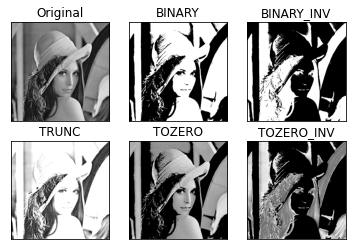

In [5]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

img = cv2.imread('img/lenna.png', 0)

ret, thresh1 = cv2.threshold(img,127,255, cv2.THRESH_BINARY)
ret, thresh2 = cv2.threshold(img,127,255, cv2.THRESH_BINARY_INV)
ret, thresh3 = cv2.threshold(img,127,255, cv2.THRESH_TRUNC)
ret, thresh4 = cv2.threshold(img,127,255, cv2.THRESH_TOZERO)
ret, thresh5 = cv2.threshold(img,127,255, cv2.THRESH_TOZERO_INV)

titles =['Original','BINARY','BINARY_INV','TRUNC','TOZERO','TOZERO_INV']
images = [img,thresh1,thresh2,thresh3,thresh4,thresh5]

for i in range(6):
    plt.subplot(2,3,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])

plt.show()

자동 이진화  
히스토그램을 분석하여 배경과 객체의 중간 값 추출하여 임계값으로 설정  
  
cv2.THRESH_OTSU

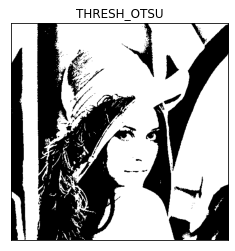

In [10]:
img = cv2.imread('img/lenna.png',0)
ret, thresh1 = cv2.threshold(img,0,255, cv2.THRESH_BINARY|cv2.THRESH_OTSU) #임계값은 0으로 해놔도 자동으로 설정
plt.imshow(thresh1,'gray')
plt.title('THRESH_OTSU')
plt.xticks([]),plt.yticks([])

plt.show()

지역 이진화  
균일하지 않은 밝기 영상의 이진화  
   
   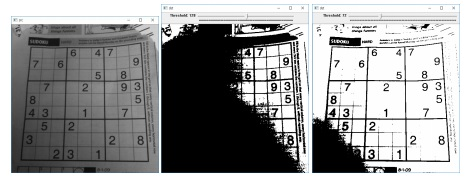  
   
=>해결: 이미지를 일정 크기의 사각형으로 분할하여 각 영역 내부의 픽셀 값 분포에 맞게 임계값 결정하여 이진화  


In [12]:
import sys
import numpy as np
import cv2


# 입력 영상 불러오기
src = cv2.imread('img/sudoku.jpg', cv2.IMREAD_GRAYSCALE)

if src is None:
    print('Image load failed!')
    sys.exit()

# 전역 이진화 by Otsu's method
_, dst1 = cv2.threshold(src, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

# 지역 이진화 by Otsu's method
dst2 = np.zeros(src.shape, np.uint8)

bw = src.shape[1] // 4
bh = src.shape[0] // 4
# 4x4 = 16칸으로 나눔

for y in range(4):
    for x in range(4):
        src_ = src[y*bh:(y+1)*bh, x*bw:(x+1)*bw]
        dst_ = dst2[y*bh:(y+1)*bh, x*bw:(x+1)*bw]
        cv2.threshold(src_, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU, dst_)

# 결과 출력
cv2.imshow('src', src)
cv2.imshow('dst1', dst1)
cv2.imshow('dst2', dst2)
cv2.waitKey()
cv2.destroyAllWindows()

적응형 이진화  
  
cv2.adaptiveThreshold(src, maxVal, adaptiveMethod, thresholdType, blockSize, C, dst) => dst(결과영상)  
  
maxVal: 임계값 함수 최대값(255)  
adaptiveMethod: 블록 평균 계산 방법. cv2.ADAPTIVE_THRESH_MEAN_C(산술평균), cv2.ADAPTIVE_THRESH_GAUSSIAN_C(가우시안 가중치 평균)  
thresholdType: 이진화 방법. cv2.THRESH_BINARY, cv2.THRESH_INV  
blockSize: 블록크기. 3이상의 홀수  
C: 평균에서 뺄값.  

In [13]:
import sys
import numpy as np
import cv2


src = cv2.imread('img/sudoku.jpg', cv2.IMREAD_GRAYSCALE)

if src is None:
    print('Image load failed!')
    sys.exit()


def on_trackbar(pos):
    bsize = pos
    if bsize % 2 == 0:
        bsize = bsize - 1
    if bsize < 3:
        bsize = 3

    dst = cv2.adaptiveThreshold(src, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                cv2.THRESH_BINARY, bsize, 5)

    cv2.imshow('dst', dst)


cv2.imshow('src', src)
cv2.namedWindow('dst')
cv2.createTrackbar('Block Size', 'dst', 0, 200, on_trackbar)
cv2.setTrackbarPos('Block Size', 'dst', 11)

cv2.waitKey()
cv2.destroyAllWindows()


In [41]:
src = cv2.imread('img/sudoku.jpg', cv2.IMREAD_GRAYSCALE)

dst = cv2.adaptiveThreshold(src, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 59, 4)

cv2.imshow('src', src)
cv2.imshow('dst', dst)
cv2.waitKey()
cv2.destroyAllWindows()

2. 모폴로지  
  
  영상을 형태학적 측면에서 다루는 기법  
  영상의 전처리나 후처리로 많이 사용됨  
    
1) 침식과 팽창  
침식: 커널이 객체 영역 안에 모두 포함될때 앵커(고정점)를 255로 설정  
      객체 외각을 깍아내는 연산 => 객체 크기 감소. 배경 확대 효과  
      => 실제 영상에서 작은 크기의 잡음 제거 효과
      
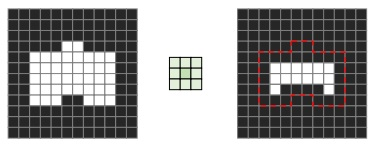
      
      cv2.erode(src, kernel, anchor, iterations, borderType, borderValue)  => dst  
      kernel: None이면 3x3  
      anchor: 고정점 위치. 기본값(-1,-1)은 정중앙점  
      iterations: 반복횟수. 기본값 1.  
      borderType: 테두리 처리 종류  
      borderValue: 확장 테두리 채울 값  
      
팽창: 커닐이 객체 영역 안에 하나라도 포함되면 앵커(고정점)를 255로 설정  
      객체 외각을 확대시키는 연산 => 객체 크기 확대. 배경 감소 효과  
      => 실제 영상에서 내부 홀(구멍)을 채우는 효과  
      
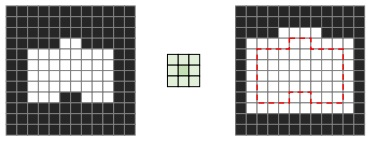
      
      cv2.dilate(src, kernel, anchor, iterations, borderType, borderValue)  => dst  
      kernel: None이면 3x3  
      anchor: 고정점 위치. 기본값(-1,-1)은 정중앙점  
      iterations: 반복횟수. 기본값 1.  
      borderType: 테두리 처리 종류  
      borderValue: 확장 테두리 채울 값  
      
모폴로지 커널 생성  
cv2.getStructuringElement(shape, ksize, anchor) => res  
shape: 커널모양.  
       cv2.MORTH_RECT: 사각형 모양  
       cv2.MORTH_CROSS: 십자가 모양  
       cv2.MORPH_ELLIPSE: 사각형에 내접하는 타원  
ksize: 커널크기. (가로, 세로)튜플  
anchor: 앵커 위치. (-1, -1)은 중앙점  
res: 0, 1로 구성된 행렬(커널).  

In [42]:
import sys
import numpy as np
import cv2


src = cv2.imread('img/circuit.bmp', cv2.IMREAD_GRAYSCALE)

if src is None:
    print('Image load failed!')
    sys.exit()

se = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 3))
dst1 = cv2.erode(src, se)

dst2 = cv2.dilate(src, None)

cv2.imshow('src', src)
cv2.imshow('dst1', dst1)
cv2.imshow('dst2', dst2)
cv2.waitKey()
cv2.destroyAllWindows()


In [4]:
se

array([[1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1]], dtype=uint8)

2) opening과 closing  
opening: erode 후 dilate   
closing:  dilate 후 erode  
  
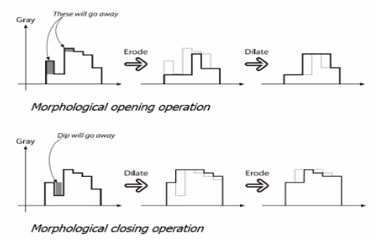  
  
opening => 작은 개체나 돌기 제거. 얇은 선 끊어짐  
closing => 작은 홈이나 홀 사라지고 얇은 연결선이 두꺼워짐. 윤곽 파악에 적합  
  
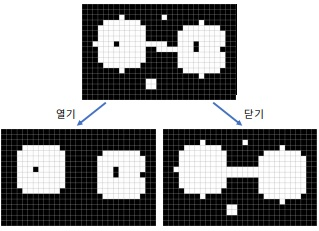  
  
범용 모톨로지 연산 함수  
  모톨로지 침식, 팽창, 오프닝, 클로징 등의 연산을 하나의 함수로 실행할 수 있음.  
  
cv2.morphologyEx(src, mode, kernel,anchor,iterations,borderType, borderValue) => dst  
  
mode: 연산 종류  
   cv2.MORPH_ERODE: 침식  
   cv2.MORPH_DILATE: 팽창  
   cv2.MORPH_OPEN:  opening  
   cv2.MORPH_CLOSE: closing  
   cv2.MORPH_GRADIENT: dilate 결과 – erode결과(d와 e의 차)  
 

In [43]:
import sys
import numpy as np
import cv2


src = cv2.imread('img/rice.png', cv2.IMREAD_GRAYSCALE)

if src is None:
    print('Image load failed!')
    sys.exit()

# src 영상에 지역 이진화 수행 (local_th.py 참고)
dst1 = np.zeros(src.shape, np.uint8)

bw = src.shape[1] // 4
bh = src.shape[0] // 4

for y in range(4):
    for x in range(4):
        src_ = src[y*bh:(y+1)*bh, x*bw:(x+1)*bw]
        dst_ = dst1[y*bh:(y+1)*bh, x*bw:(x+1)*bw]
        cv2.threshold(src_, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU, dst_)

cnt1, _ = cv2.connectedComponents(dst1)  # 연결되어 있는 픽셀을 하나의 객체로 인식하여 count 해주는 함수, 쌀알 개수
print('cnt1:', cnt1)

dst2 = cv2.morphologyEx(dst1, cv2.MORPH_OPEN, None)
#dst2 = cv2.erode(dst1, None)
#dst2 = cv2.dilate(dst2, None)

cnt2, _ = cv2.connectedComponents(dst2)
print('cnt2:', cnt2)

cv2.imshow('src', src)
cv2.imshow('dst1', dst1)
cv2.imshow('dst2', dst2)
cv2.waitKey()
cv2.destroyAllWindows()


cnt1: 113
cnt2: 99


In [48]:
import sys
import numpy as np
import cv2

src = cv2.imread('img/rice.png', cv2.IMREAD_GRAYSCALE)
src = cv2.resize(src, None, fx=0.8, fy=0.8, interpolation=cv2.INTER_AREA)

_, temp = cv2.threshold(src, 0, 255, cv2.THRESH_BINARY|cv2.THRESH_OTSU)

dst1 = cv2.morphologyEx(temp, cv2.MORPH_OPEN, None)
dst2 = cv2.morphologyEx(temp, cv2.MORPH_CLOSE, None)
#dst2 = cv2.erode(dst1, None)
#dst2 = cv2.dilate(dst2, None)

cv2.imshow('src', src)
cv2.imshow('temp', temp)
cv2.imshow('opening', dst1)
cv2.imshow('closing', dst2)
cv2.waitKey()
cv2.destroyAllWindows()


3. 레이블링  
  
객체 단위 분석: 객체를 분할하여 특징 분석. 객체 위치, 크기 정보, roi 추출, 모양 분석 등  
  
레이블링: 서로 연결되어 있는 객체 픽셀에 고유 번호 할당. 영역 기반 모양 분석. 레이블맵, 바운딩 박스, 픽셀 개수, 무게 중심 좌표 반환  
  
외곽선 검출: 객체 외곽선 좌표 검출. 외곽선 기반 모양 분석. 다양한 외곽선 처리 함수에서 활용(근사화, 컨벡스 헐 등)  
  
1)레이블링  
동일 객체에 속한 모든 픽셀에 고유번호 할당  
보통  이진 영상에서 수행  
  
픽셀 연결 관계  
4-이웃 연결관계  
8-이웃 연결관계 
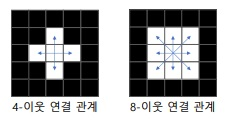
  
  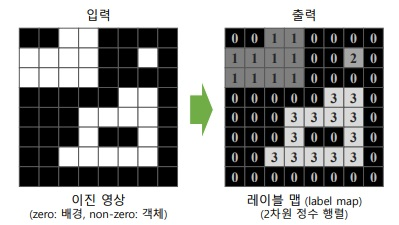  
  
레이블링 함수  
cv2.connectedComponents(src, connectivity, ltype) => retval, labels  
src: 8비트 1채널 영상  
connectivity: 4 또는 8. 기본값은 8  
ltype: labels 타입. 기본값은 cv2.CV_32S  
retval: 객체 개수(레이블 개수) N반환. 카운팅은 0부터 이고 0은 배경객체. 실제 객체 개수는 N-1개  
  
cv2.connectedComponentsWithStats(src, connectivity, ltype) => retval, labels, stats, centroids  
src: 8비트 1채널 영상  
connectivity: 4 또는 8. 기본값은 8  
ltype: labels 타입. 기본값은 cv2.CV_32S  
stats: 추출된 객체의 위치, 가로세로 길이, 면적 등의 정보  
centroids: 무게중심 정보  
  
  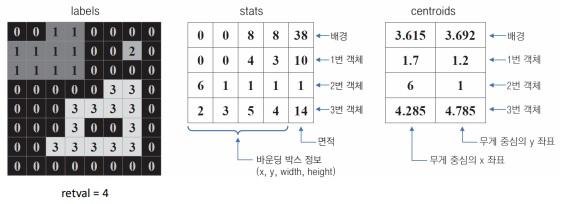  
  

In [5]:
import sys
import numpy as np
import cv2


src = cv2.imread('img/keyboard.bmp', cv2.IMREAD_GRAYSCALE)
src = cv2.GaussianBlur(src, (3,3), 2)  # 노이즈 제거
_, src_bin = cv2.threshold(src, 0, 255, cv2.THRESH_OTSU)  # 영상 이진화

cnt, labels, stats, centroids = cv2.connectedComponentsWithStats(src_bin)

dst = cv2.cvtColor(src, cv2.COLOR_GRAY2BGR)

for i in range(1, cnt):
    x, y, w, h, area = stats[i]
    cv2.rectangle(dst, (x, y), (x+w, y+h), (0, 255, 255))

cv2.imshow('src', src)
cv2.imshow('src_bin', src_bin)
cv2.imshow('dst', dst)
cv2.waitKey()
cv2.destroyAllWindows()


연습: 레이블링으로 객체를 찾아 서로 다른색으로 출력하고 각 도형의 무게중심에 점을 출력하시오  
\+ 과제: 무게중심을 기준으로 도형을 90도씩 회전

In [8]:
import sys
import numpy as np
import cv2

src = cv2.imread('img/polygon.bmp', cv2.IMREAD_GRAYSCALE)
_, src_bin = cv2.threshold(src, 0, 255, cv2.THRESH_BINARY_INV|cv2.THRESH_OTSU)
cnt, labels, stats, centroids = cv2.connectedComponentsWithStats(src_bin)

h, w = src.shape
dst=np.zeros((h, w), dtype='uint8')  # 원본과 같은 사이즈의 판 생성

for i in range(1, cnt):
    if stats[i][4] < 20:  # stats = [x, y, w, h, 넓이]
        continue
    c = (i+1)*25
    dst[labels[:]==i]=c  # dst에 레이블이 i인 객체의 위치를 (i+1)*25 색으로 칠해라
    center = centroids[i]
    cv2.circle(dst, (int(center[0]), int(center[1])), 2, (c+100, c+100, c+100), -1)

cv2.imshow('src', src)
cv2.imshow('src_bin', src_bin)
cv2.imshow('dst', dst)
cv2.waitKey()
cv2.destroyAllWindows()

2) 외곽선 검출  
객체 외곽선 좌표 추출  
외부 외곽선 & 내부 외곽선 => 외곽선 계층 구조 표현 가능  
  
  cv2.findContours(img, mode, method, offset) => contours, hierachy  
  
mode: contours 찾는 방법 지정  
	cv2.RETR_EXTERNAL:  가장 바깥 경계선만 찾음  
	cv2.RETR_LIST:   모든 컨투어 탐색, hierachy 관계 구성 않음  
	cv2.RETR_CCOMP:   모든 컨투어 탐색,hierachy 관계 2단계 까지 구성  
	cv2.RETR_TREE:  모든 컨투어 탐색,모든 hierachy 관계 구성  
	
method: 컨투어 좌표와 관련된 설정  
	cv2.CHAIN_APPROX_NONE: 모든 컨투어 좌표 저장  
	cv2.CHAIN_APPROX_SIMPLE: 컨투어 라인을 그릴 수 있는 좌표만 저장  
	cv2.CHAIN_APPROX_TC89_L1: 컨투어 좌표 찾는 알고리즘  
	cv2.CHAIN_APPROX_TC89_KCOS: 컨투어 좌표 찾는 알고리즘  
  
offset: 좌표 이동 옵셋. 기본값(0,0)  
  
contours: 검출된 외곽선 좌표. len(contours)는 전체 길이이므로 외곽선 좌표의 개수가 됨. contours[i].shape=(k,1,2)k는 한 객체 외곽선 좌표 개수, contours[i].dtype=numpy.int32.  

hierachy: 외곽선 계층 정보. numpy.ndarray. shape=(1, N, 4). type=numpy.int32. hierarchy[0, i, 0] ~ hierarchy[0, i, 3]이 순서대로 next, prev, child, parent. 외곽선 인덱스를 가리킴. 해당 외곽선이 없으면 -1.  
  
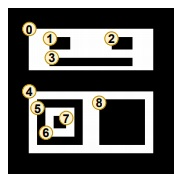  
  
cv2.RETR_EXTERNAL: 0 -> 4  
cv2.RETR_LIST: 0 -> 1 -> 2 -> 3 -> 4 -> 5 -> 6 -> 7 -> 8  
위 둘은 계층 정보 없음  
  
cv2.RETR_CCOMP: 0(1,2,3) -> 4(5,8) -> 6(7)    
cv2.RETR_TREE: 0(1,2,3) -> 4((5,6,7), 8)  
  
3) 외곽선 그리기  
cv2.drawContours(img, contours, contourIdx, color, thickness=None,
lineType=None, hierarchy=None, maxLevel=None, offset=None)
=> img  
  
contours: (cv2.findContours() 함수로 구한) 외곽선 좌표 정보  
contourIdx: 외곽선 인덱스. 음수(-1)를 지정하면 모든 외곽선을 그림  
color:외곽선 색상  
thickness:외곽선 두께. thinkness < 0이면 내부를 채움  
lineType:LINE_4, LINE_8, LINE_AA 중 하나 지정  
hierarchy:외곽선 계층 정보  
maxLevel:그리기를 수행할 최대 외곽선 레벨. maxLevel = 0 이면 contourIdx로 지정된 외곽선만 그림  
  
<사용예>  
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  
ret, thresh = cv2.threshold(gray, 127, 255, 0)  
contours, hierachy = cv2.findContours(thresh, cv2.CHAIN_APPROX_SIMPLE)  
cont_img = cv2.drawContours(img, contours, -1, (0,0,255), 2)  


In [35]:
import sys
import random
import numpy as np
import cv2


src = cv2.imread('img/contours.bmp', cv2.IMREAD_GRAYSCALE)

if src is None:
    print('Image load failed!')
    sys.exit()

mode = [cv2.RETR_EXTERNAL, cv2.RETR_LIST, cv2.RETR_CCOMP, cv2.RETR_TREE]
name = ['RETR_EXTERNAL', 'RETR_LIST', 'RETR_CCOMP', 'RETR_TREE']

for m in mode:
    contours, hier = cv2.findContours(src, m, cv2.CHAIN_APPROX_NONE)

    dst = cv2.cvtColor(src, cv2.COLOR_GRAY2BGR)

    idx = 0
    while idx >= 0:
        c = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)) #랜덤 BGR값 생성
        cv2.drawContours(dst, contours, idx, c, 2, cv2.LINE_8, hier)
        idx = hier[0, idx, 0]
    cv2.imshow(name[m], dst)

cv2.waitKey()
cv2.destroyAllWindows()


In [10]:
contours

[array([[[ 90, 240]],
 
        [[ 90, 241]],
 
        [[ 90, 242]],
 
        [[ 90, 243]],
 
        [[ 90, 244]],
 
        [[ 90, 245]],
 
        [[ 90, 246]],
 
        [[ 90, 247]],
 
        [[ 90, 248]],
 
        [[ 90, 249]],
 
        [[ 90, 250]],
 
        [[ 90, 251]],
 
        [[ 90, 252]],
 
        [[ 90, 253]],
 
        [[ 90, 254]],
 
        [[ 90, 255]],
 
        [[ 90, 256]],
 
        [[ 90, 257]],
 
        [[ 90, 258]],
 
        [[ 90, 259]],
 
        [[ 90, 260]],
 
        [[ 90, 261]],
 
        [[ 90, 262]],
 
        [[ 90, 263]],
 
        [[ 90, 264]],
 
        [[ 90, 265]],
 
        [[ 90, 266]],
 
        [[ 90, 267]],
 
        [[ 90, 268]],
 
        [[ 90, 269]],
 
        [[ 90, 270]],
 
        [[ 90, 271]],
 
        [[ 90, 272]],
 
        [[ 90, 273]],
 
        [[ 90, 274]],
 
        [[ 90, 275]],
 
        [[ 90, 276]],
 
        [[ 90, 277]],
 
        [[ 90, 278]],
 
        [[ 90, 279]],
 
        [[ 90, 280]],
 
        [[ 90, 2

In [41]:
import sys
import random
import numpy as np
import cv2


src = cv2.imread('img/milkdrop.bmp', cv2.IMREAD_GRAYSCALE)

if src is None:
    print('Image load failed!')
    sys.exit()

 

contours, _ = cv2.findContours(src_bin, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

h, w = src.shape[:2]
dst = np.zeros((h, w, 3), np.uint8)

for i in range(len(contours)):
    c = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
    cv2.drawContours(dst, contours, i, c, 1, cv2.LINE_AA)

cv2.imshow('src', src)
cv2.imshow('src_bin', src_bin)
cv2.imshow('dst', dst)
cv2.waitKey()
cv2.destroyAllWindows()


4)속성들  
*moments: 이미지의 특징들. 넓이, 중심점  
contours, hierachy = cv2.findContours(thresh, cv2.CHAIN_APPROX_SIMPLE)  
cont1 = contours[0]  
M = cv2.moments(cont1)  
print(M['m00'])#cont1 영역의 넓이 출력  
print(M['m10']/M['m00']) #중심점의 x좌표  
print(M['m01']/M['m00']) #중심점의 y좌표  
  
*contour영역의 넓이  
cv2.contourArea(cont1)#넓이 반환  
  
*contour 둘레 길이  
cv2.arcLength(cont1, True/False)#True:막힌영역, False:뚫린 영역 의미  
  
*contour의 포인트 줄이기 – 대략적 모양은 유지  
cv2.approxPolyDP(cont1, 근사치, True/False)#True:막힌영역, False:뚤린 영역 의미	=>리턴값: 근사치로 줄인 포인트 array  
  
<사용예>  
p1 = 0.01 * cv2.arcLength(cont1, True)#곱하는 숫자가 클수록 점의 수는 작아짐  
p2 = 0.1 * cv2.arcLength(cont1, True)  
  	
ap = cv2.approxPolyDP(cont1, p1, True)  
cont_img = cv2.drawContours(img, [ap], 0, (0,0,255), 2)  
  
*convex hull  
contour의 모든 점을 포함하면서 볼록한 점들을 연결한 선  
contours, hierachy = cv2.findContours(thresh, cv2.CHAIN_APPROX_SIMPLE)  
for cnt in contours:  
     hull = cv2.convexHull(cnt)#convex hull 추출   
     cont_img = cv2.drawContours(img, [hull], 0, (0,0,255), 2)	
  
*bounding rectangle  
컨투어 영역을 모두 포함한 사각형의 좌측 상단 좌표와 가로, 세로 길이 반환  
contours, hierachy = cv2.findContours(thresh, cv2.CHAIN_APPROX_SIMPLE)  
cont1 = contours[0]  
x,y,w,h = cv2.boundingRect(cont1)  
img = cv2.rectangle(img, (x,y), (x+w, y+h), (0,0,255),2)  
  
*최소한의 사각형(컨투어 각도에 맞추어 사각형 만듦)  
rect = cv2.minAreaRect(cont1)#컨투어를 포함한 최소한 크기의 사각형  
box = cv2.boxPoints(rect)#사각형의 4점을 반환  
cont_img = cv2.drawContours(img, [box], 0, (0,0,255), 2)  
  
*컨투어 포함한 원  
#컨투어를 포함한 원의 중심점 좌표와 반지름 반환  
(x, y), r = cv2.minEnclosingCircle(cont1)  
  
*컨투어 포함한 타원  
e = cv2.fitEllipse(cont1)#컨투어를 포함한 타원의 정보 반환  
  
*컨투어의 가로, 세로 비율  
x,y,w,h = cv2.boundingRect(cont1)  
r = w/h  
  
*컨투어 면적과 bounding 면적의 비  
area = cv2.contourArea(cont1)  
x,y,w,h = cv2.boundingRect(cont1)  
b_area = w*h  
r =area/b_area  
  
*컨투어 면적과 convex hull 면적의 비  
area = cv2.contourArea(cont1)  
hull = cv2.convexHull(cont1)  
h_area = area = cv2.contourArea(hull)  
r = area/h_area  
  
*컨투어를 영역의 동서남북 4꼭지점 찾기  
leftmost = tuple(cnt[cnt[:,:,0].argmin()][0])  
rightmost = tuple(cnt[cnt[:,:,0].argmax()][0])  
topmost = tuple(cnt[cnt[:,:,1].argmin()][0])  
bottommost = tuple(cnt[cnt[:,:,1].argmax()][0])  
  
*컨투어 계층구조(hierachy)  
contours, hierachy = cv2.findContours(thresh, cv2.CHAIN_APPROX_SIMPLE)  	
print(hierachy)  
=>실행결과  
array([[[ 1, -1, -1, -1],		#[next, prev, child, parent]. -1은 없음을 의미  
        [ 2,  0, -1, -1],  
        [ 3,  1, -1, -1],  
        [ 4,  2, -1, -1],  
        [ 5,  3, -1, -1],  
        [ 6,  4, -1, -1],  
        [ 7,  5, -1, -1],  
        [ 8,  6, -1, -1],  
        [-1,  7, -1, -1]]])  


5) 외곽선 관련 함수
  
cv2.arcLength(): 외곽선 길이를 반환  
  
cv2.contourArea(): 외곽선이 감싸는 영역의 면적을 반환  
  
cv2.boundingRect(): 주어진 점을 감싸는 최소 크기 사각형(바운딩 박스) 반환  
  
cv2.minEnclosingCircle(): 주어진 점을 감싸는 최소 크기 원을 반환  
  
cv2.minAreaRect(): 주어진 점을 감싸는 최소 크기 회전된 사각형을 반환  
  
cv2.minEnclosingTriangle(): 주어진 점을 감싸는 최소 크기 삼각형을 반환  
  
cv2.approxPolyDP(): 외곽선을 근사화(단순화)  
  
cv2.fitEllipse(): 주어진 점에 적합한 타원을 반환  
  
cv2.fitLine(): 주어진 점에 적합한 직선을 반환  
  
cv2.isContourConvex(): 컨벡스인지를 검사  
  
cv2.convexHull(): 주어진 점으로부터 컨벡스 헐을 반환  
  
cv2.convexityDefects(): 주어진 점과 컨벡스 헐로부터 컨벡스 디펙트를 반환  

6) 다각형 검출 프로그램  
  
구현 순서  
1)이진화  
2)외곽선 찾기  
3)외곽선 근사화  
4)너무 작은 객체와 컨벡스가 아닌 객체 제외  
5)꼭지점 개수 확인 => 삼각형, 사각형 검출 => 원 판별  
  
<원판별>  
객체 외곽선 길이에 대한 넓이 비율이 가장 넓음  
=>도형 넓이와 외곽선 길이의 비율 검사 => 결과가 1에 가까울수록 원으로 판단  
  
length = cv2.arcLength(pts, True)  
area = cv2.contourArea(pts)  
#도형 넓이와 외곽선 길이의 비율 검사  
ratio = 4. * math.pi * area / (length * length)  
if ratio > 0.85:   #비율 결과가 1에 가까우면  
setLabel(img, pts, '원')  

In [56]:
src = cv2.imread('img/milkdrop.bmp', cv2.IMREAD_GRAYSCALE)

if src is None:
    print('Image load failed!')
    sys.exit()

_, src_bin = cv2.threshold(src, 0, 255, cv2.THRESH_OTSU)

contours, _ = cv2.findContours(src_bin, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

h, w = src.shape[:2]
dst = np.zeros((h, w, 3), np.uint8)

for i in range(len(contours)):
    points = contours[i]
    area = cv2.contourArea(points)
    if area > 600:
        c = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
        cv2.drawContours(dst, contours, i, c, 1, cv2.LINE_AA)
        m = cv2.moments(points)
        x = m['m10']/m['m00']
        y = m['m01']/m['m00']
        cv2.circle(dst, (int(x), int(y)), 3, c, -1)

cv2.imshow('src', src)
cv2.imshow('src_bin', src_bin)
cv2.imshow('dst', dst)
cv2.waitKey()
cv2.destroyAllWindows()


In [69]:
import random
import numpy as np
import cv2

src = cv2.imread('img/milkdrop.bmp', cv2.IMREAD_GRAYSCALE)
_, src_bin = cv2.threshold(src, 0, 255, cv2.THRESH_OTSU)
contours, _ = cv2.findContours(src_bin, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

h, w = src.shape[:2]
dst = np.zeros((h, w, 3), np.uint8)

for i in range(len(contours)):
    points = contours[i]
    area = cv2.contourArea(points)
    if area > 600:
        #외곽선 그리기
        c = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
        cv2.drawContours(dst, contours, i, c, 1, cv2.LINE_AA)
        
        #외곽선으로 모멘트 계산
        m = cv2.moments(points)
        
        #외곽선의 중심점 좌표
        x = m['m10']/m['m00']
        y = m['m01']/m['m00']
        cv2.circle(dst, (int(x),int(y)), 3, c, -1)
        
        #외곽선 둘레 * 0.01
        p1 = 0.01 * cv2.arcLength(points, True)
        #외곽선 근사화(점의 수를 줄임)
        ap = cv2.approxPolyDP(points, p1, True)
        c = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
        #계산된 근사치 좌표로 외곽선 그림
        cv2.drawContours(dst, [ap], 0, c, 1, cv2.LINE_AA)
        
cv2.imshow('src', src)
cv2.imshow('src_bin', src_bin)
cv2.imshow('dst', dst)
cv2.waitKey()
cv2.destroyAllWindows()

In [85]:
import numpy as np
import cv2

src = cv2.imread('img/milkdrop.bmp', cv2.IMREAD_GRAYSCALE)
_, src_bin = cv2.threshold(src, 0, 255, cv2.THRESH_OTSU)
contours, _ = cv2.findContours(src_bin, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

h, w = src.shape[:2]
dst = np.zeros((h, w, 3), np.uint8)

for cont in contours:
    area = cv2.contourArea(cont)
    if area > 600:
        cv2.drawContours(dst, [cont], 0, (255, 0, 0), 1, cv2.LINE_AA)
        hull = cv2.convexHull(cont)
        cv2.drawContours(dst, [hull], 0, (0, 0, 255), 1, cv2.LINE_AA)
        
cv2.imshow('src', src)
cv2.imshow('src_bin', src_bin)
cv2.imshow('dst', dst)
cv2.waitKey()
cv2.destroyAllWindows()

**<도형 구분>**  
폴리곤 이미지 파일을 읽어서
컨벡스 헐 처리 후 좌표의 개수로
삼각형, 사각형, 다각형을 구분하는 코드 작성

In [86]:
import math
import cv2


def setLabel(img, pts, label):
    (x, y, w, h) = cv2.boundingRect(pts)
    pt1 = (x, y)
    pt2 = (x + w, y + h)
    cv2.rectangle(img, pt1, pt2, (0, 0, 255), 1)
    cv2.putText(img, label, pt1, cv2.FONT_HERSHEY_PLAIN, 1, (0, 0, 255))


def main():
    img = cv2.imread('img/polygon.bmp', cv2.IMREAD_COLOR)

    if img is None:
        print('Image load failed!')
        return

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, img_bin = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(img_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    for pts in contours:
        if cv2.contourArea(pts) < 400:  #  너무 작으면 무시
            continue

        approx = cv2.approxPolyDP(pts, cv2.arcLength(pts, True)*0.02, True)

        vtc = len(approx)

        if vtc == 3:
            setLabel(img, pts, 'TRI')
        elif vtc == 4:
            setLabel(img, pts, 'RECT')
        else:
            length = cv2.arcLength(pts, True)
            area = cv2.contourArea(pts)
            ratio = 4. * math.pi * area / (length * length)

            if ratio > 0.85:
                setLabel(img, pts, 'CIR')

    cv2.imshow('img', img)
    cv2.waitKey()
    cv2.destroyAllWindows()


main()


In [87]:
import numpy as np
import cv2

src = cv2.imread('img/polygon.bmp', cv2.IMREAD_GRAYSCALE)
_, src_bin = cv2.threshold(src, 0, 255, cv2.THRESH_BINARY_INV|cv2.THRESH_OTSU)
contours, _ = cv2.findContours(src_bin, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

h, w = src.shape[:2]
dst = np.zeros((h, w, 3), np.uint8)

for cont in contours:
    area = cv2.contourArea(cont)
    if area > 600:
        cv2.drawContours(dst, [cont], 0, (255, 0, 0), 1, cv2.LINE_AA)
        p1 = 0.01 * cv2.arcLength(cont, True)
        ap = cv2.approxPolyDP(cont, p1, True)
        hull = cv2.convexHull(ap)
        p_cnt = len(hull)
        if p_cnt==3:
            label = 'tri'
        elif p_cnt == 4:
            label = 'rect'
        elif 4 < p_cnt < 10:
            label = 'poly'
        elif p_cnt >=10 :
            label = 'circle'
        
        cv2.drawContours(dst, [hull], 0, (0, 0, 255), 1, cv2.LINE_AA)
        x = cont[cont[:,:,0].argmin()][0][0]
        y = cont[cont[:,:,1].argmin()][0][1]
        cv2.putText(dst, label, (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 1, (200,200,200))
        print(x, y)
        
cv2.imshow('dst', dst)
cv2.waitKey()
cv2.destroyAllWindows()

65 285
404 275
247 271
440 205
139 166
427 71
263 58
70 34


<컨투어 직사각형으로 표현>

In [ ]:
import numpy as np
import cv2

src = cv2.imread('img/polygon.bmp', cv2.IMREAD_GRAYSCALE)
_, src_bin = cv2.threshold(src, 0, 255, cv2.THRESH_BINARY_INV|cv2.THRESH_OTSU)
contours, _ = cv2.findContours(src_bin, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

h, w = src.shape[:2]
dst = np.zeros((h, w, 3), np.uint8)

for cont in contours:
    area = cv2.contourArea(cont)
    if area > 600:
        cv2.drawContours(dst, [cont], 0, (255, 0, 0), 1, cv2.LINE_AA)
        x,y,w,h = cv2.boundingRect(cont)
        img = cv2.rectangle(dst, (x,y), (x+w, y+h), (0,0,255),2)
        
cv2.imshow('dst', dst)
cv2.waitKey()
cv2.destroyAllWindows()

<컨투어에서 네 꼭지점 찾기>

In [82]:
import numpy as np
import cv2

src = cv2.imread('img/polygon.bmp', cv2.IMREAD_GRAYSCALE)
_, src_bin = cv2.threshold(src, 0, 255, cv2.THRESH_BINARY_INV|cv2.THRESH_OTSU)
contours, _ = cv2.findContours(src_bin, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

h, w = src.shape[:2]
dst = np.zeros((h, w, 3), np.uint8)

for cont in contours:
    area = cv2.contourArea(cont)
    if area > 600:
        cv2.drawContours(dst, [cont], 0, (255, 0, 0), 1, cv2.LINE_AA)
        x_min = cont[cont[:,:,0].argmin()][0]#컨투어에서 x 최소값
        y_min = cont[cont[:,:,1].argmin()][0]
        x_max = cont[cont[:,:,0].argmax()][0]
        y_max = cont[cont[:,:,1].argmax()][0]
        
        cv2.circle(dst, (x_min[0], x_min[1]), 3, (0, 0, 255), -1)
        cv2.circle(dst, (y_min[0], y_min[1]), 3, (0, 0, 255), -1)
        cv2.circle(dst, (x_max[0], x_max[1]), 3, (0, 0, 255), -1)
        cv2.circle(dst, (y_max[0], y_max[1]), 3, (0, 0, 255), -1)
        
        
cv2.imshow('dst', dst)
cv2.waitKey()
cv2.destroyAllWindows()

<컨투어 최소 사각형으로 표시>

In [80]:
import numpy as np
import cv2

src = cv2.imread('img/polygon.bmp', cv2.IMREAD_GRAYSCALE)
_, src_bin = cv2.threshold(src, 0, 255, cv2.THRESH_BINARY_INV|cv2.THRESH_OTSU)
contours, _ = cv2.findContours(src_bin, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

h, w = src.shape[:2]
dst = np.zeros((h, w, 3), np.uint8)

for cont in contours:
    area = cv2.contourArea(cont)
    if area > 600:
        cv2.drawContours(dst, [cont], 0, (255, 0, 0), 1, cv2.LINE_AA)
        rect = cv2.minAreaRect(cont) #컨투어를 포함한 최소한 크기의 사각형
        box = cv2.boxPoints(rect) #사각형의 4점을 반환      
        box = box.astype('int32')
        cv2.drawContours(dst, [box], 0, (0,0,255), 2, cv2.LINE_AA)
        
cv2.imshow('dst', dst)
cv2.waitKey()
cv2.destroyAllWindows()

과제1: 명함 추출하여 텍스트 출력    
과제2: 자동차 번호판 인식  